<a href="https://colab.research.google.com/github/ming-zhao/AIML_for_Business/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext pretty_jupyter

Execute the following code block to import all necessary packages.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
from keras import models, layers
from keras import backend as K
from keras.preprocessing import image
from keras.utils import to_categorical, load_img, img_to_array, array_to_img
from keras.utils.data_utils import get_file
from keras.applications import VGG16, xception
from urllib.request import urlopen

%matplotlib inline

base = ("https://raw.githubusercontent.com/ming-zhao/ming-zhao.github.io"
        "/master/AIML_for_Business/Computer_Vision/")

# Introduction to Convnet

Convolutional neural networks, or convnets, are widely used in computer vision applications due to their invariance to certain transformations of the inputs. The main difference between densely connected layers and convolution layers is that dense layers learn global patterns in their input feature space (e.g., for a MNIST digit, patterns involving all pixels), while convolution layers learn local patterns.

Convnets have two interesting properties:

- They learn *translation-invariant* patterns, meaning that after learning a pattern in a certain part of an image, a convnet can recognize it anywhere. In contrast, a densely connected network would have to learn the pattern anew if it appeared in a new location. This property is useful because the visual world is fundamentally translation-invariant, and convnets require fewer training samples to learn representations with generalization power.

- They can learn *spatial hierarchies* of patterns. For example, a first convolution layer learns small local patterns such as edges, a second convolution layer learns larger patterns made up of the features of the first layers, such as nose and eye, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts because the visual world is fundamentally spatially hierarchical.

Next, we will use a convnet to classify MNIST digits. We previously performed this task using a densely connected network, which achieved a test accuracy of approximately 97.8%. However, even though the convnet we will use is basic, its accuracy will far surpass that of the densely connected model.

In [ ]:
to_categorical([[0], [2], [3]])

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    model.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0);
    return model

# model = build_model()
model = models.load_model(get_file(origin=base + '/data/minst_cnn.h5'))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy is {}%'.format(round(test_acc*100,2)))    
model.summary()

313/313 [==============================] - 1s 2ms/step - loss: 0.0291 - accuracy: 0.9924
Test accuracy is 99.24%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
         

The model includes a series of `Conv2D` and `MaxPooling2D` layers, which we will examine in more detail.

## Convolution

The `Conv2D` layer uses the convolution operation, which is explained in the following figure. In this example, the input image has a size of 6x6, and the weight of the layer is 3x3 with a bias of 0.

<img src="https://github.com/ming-zhao/ming-zhao.github.io/raw/master/AIML_for_Business/Computer_Vision/figures/Computer%20Vision.gif" width="700">

When using dense layers, we create 512 28x28 filter images, and each filter image is compared to the entire input image, which means that dense layers can only learn global patterns, i.e., they learn the input image as a whole. However, the Conv2D layer, which is used in the following code snippet:
```python
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
```
uses 32 3x3 filter images that slide along the input image and capture local patterns. As these filter images move across the input image, the convnet can learn translation-invariant patterns.

Note that using a filter image will shrink the output dimension. In the previous example, the filter image reduced the 6x6 input to a 4x4 output. If we want to maintain the same spatial dimensions for the output feature map as the input, we can add an appropriate number of rows and columns on each side of the input feature map with 0 values (see the diagram below). This is known as padding, as illustrated in the following figure.

<img src="https://github.com/ming-zhao/ming-zhao.github.io/raw/master/AIML_for_Business/Computer_Vision/figures/padding.jpg" width="700">

The following code demonstrates how the convolution operation can detect the edges in an image. For every pixel in the image it multiplies it by 1 and subtracts the 0.125 of all the surrounding pixel values from it. This way the maximum effect is observed at the edges where there is stark difference between the pixel value and its surroundings. However in any other region the effect will be cancelled as the filter overall sums to 0.

filter:
 [[-0.125 -0.125 -0.125]
 [-0.125  1.    -0.125]
 [-0.125 -0.125 -0.125]]


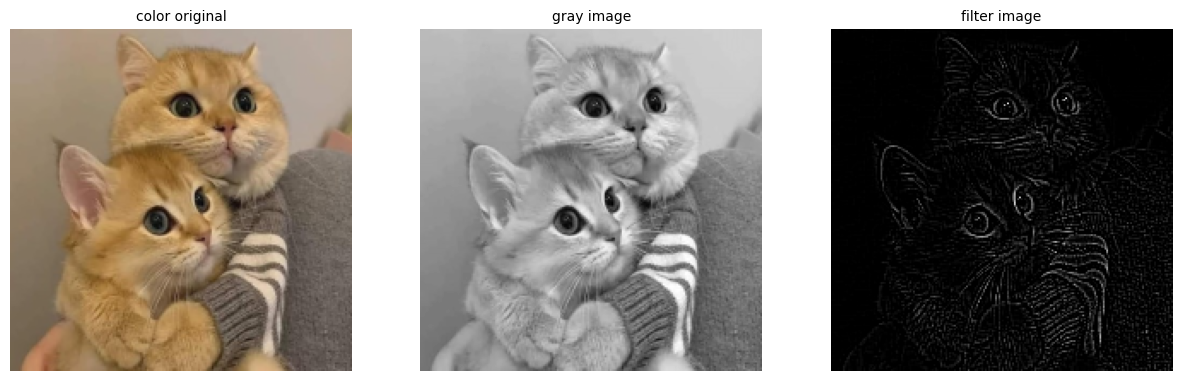

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy.signal import convolve2d

url = base + "/figures/cat.jpg"
image = resize(plt.imread(urlopen(url), format='jpg'), (200,200))

plt.figure(figsize=(15,8))
# plot the original image
plt.subplot(1,3,1)
plt.title('color original', fontsize=10)
plt.axis('off')
plt.imshow(image)

# plot the gray image
gray_img = rgb2gray(image)
plt.subplot(1,3,2)
plt.title('gray image', fontsize=10)
plt.axis('off')
plt.imshow(gray_img, cmap='gray')

# create and print filter
flt = -np.ones((3,3))/8
flt[1,1] = 1
print('filter:\n', flt)

# plot the filtered image
flt_img = convolve2d(gray_img, flt, boundary='symm', mode='same')
plt.subplot(1,3,3)
flt_img = np.maximum(0, flt_img)
plt.title('filter image', fontsize=10)
plt.imshow(flt_img, cmap='gray')
plt.axis('off')
plt.show()

The step size of sliding a filter is a parameter of the convolution, called its stride. The stride in the graph below is 2 because we slide the filter over input by 2 tiles.

<img src="https://github.com/ming-zhao/ming-zhao.github.io/raw/master/AIML_for_Business/Computer_Vision/figures/stride.jpg" width="600">

Using stride 2 means the width and height of the feature map are downsampled by a factor of 2. However, Strided convolutions are rarely used in practice. To downsample feature maps, instead of strides, we tend to use the max-pooling operation.

## Max Pooling

The role of max pooling is to aggressively downsample the input image. The code snippet in the example
```python
model.add(layers.MaxPooling2D((2, 2)))
```
shows that, before the first MaxPooling2D layer, the feature map is 26 × 26, but after the max-pooling operation, it is halved to 13 × 13. It works as illustrated in the following figure.

<img src="https://github.com/ming-zhao/ming-zhao.github.io/raw/master/AIML_for_Business/Computer_Vision/figures/maxpooling.jpg" width="600">


- The pooling operation performs dimensionality reduction by reducing the output size of the convolutional layer. This reduces the number of parameters in the network, which in turn reduces the risk of overfitting.

- The max operation selects the maximum value in each subregion of the input, providing the following benefits:
    - Translation invariance: the output of the operation remains the same even if the input image is shifted slightly. This property makes the network more robust to changes in the position of objects in the input image.

    - Feature learning: the max value helps in identifying the most important features of an image by selecting the strongest feature present in each subregion. This highlights important features of the input image and allows the network to learn more effective representations of the data.
    
Let's consider the option without max pooling layers:
```python
from keras import models, layers
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.summary()
```

The summary of the model is as follows:
| Layer (type) | Output Shape | Param # |
|--------------|--------------|---------|
| conv2d_1 (Conv2D) | (None, 26, 26, 32) | 320 |
| conv2d_2 (Conv2D) | (None, 24, 24, 64) | 18496 |
| conv2d_3 (Conv2D) | (None, 22, 22, 64) | 36928 |   
|Total params: 55,744
|Trainable params: 55,744
|Non-trainable params: 0


As shown in the figure, 
<img src="https://github.com/ming-zhao/ming-zhao.github.io/raw/master/AIML_for_Business/Computer_Vision/figures/nomaxpooling.jpg" width="600">

an output element of the last layer contains information coming from a 7 $\times$ 7 window of input. It is impossible to recognize a digit by only looking at it through windows that are 7 $\times$ 7 pixels. We need the features from the last convolution layer to contain information about the entirety of the input.

The final output has 22 $\times$ 22 $\times$ 64 = 30,976 elements per sample. If we were to flatten it and then add a Dense layer of size 64 on top, that layer would have about (30,976 $\times$ 64 $\approx$) 15.8 million parameters. This is far too large for such a small model and would result in overfitting.

In summary, the reason for using downsampling is to:

- induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows of input,
- reduce the number of coefficients to avoid overfitting.

# Dogs vs. Cats

The training and validation data used in this section can be downloaded by executing the following code block.

In [ ]:
# download training and validation data to current folder
from urllib.request import urlretrieve
import zipfile

url = base + "/data/dogs-vs-cats_small.zip?raw=true"
filename = "dogs-vs-cats_small.zip"

# Download the file
urlretrieve(url, filename)

# Extract the contents of the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

The dataset contains 2,000 training pictures of cats and dogs (1,000 cats and 1,000 dogs) and 1,000 validation pictures (500 cats and 500 dogs). We will construct a small convolutional neural network to classify images as either dogs or cats.

Before we start building neural network models, we will introduce two functions:

- `validation_plot`, which will plot the training accuracy and loss versus validation

- `plot_test_images`, which will show the performance of the model on 20 testing pictures of cats and dogs (10 cats and 10 dogs).

In [ ]:
def validation_plot(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and validation accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and validation loss')
    plt.legend(bbox_to_anchor=(1.02, 0.2), loc=2, borderaxespad=0.5)
    plt.show()
    
def plot_test_images(model):
    fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
    # URLs of cat and dog images
    cat_urls = [base + "data/dogs-vs-cats_small_test/cat.{}.jpg?raw=true".format(i) for i in range(1500, 1510)]
    dog_urls = [base + "data/dogs-vs-cats_small_test/dog.{}.jpg?raw=true".format(i) for i in range(1500, 1510)]

    # Loop over cat and dog images and plot them in corresponding rows
    for i, urls in enumerate([cat_urls, dog_urls]):
        for j, url in enumerate(urls):
            # Load the image from URL
            img = load_img(get_file(f"cats_and_dogs_small_test{i}{j}.jpg", origin=url), target_size=(150, 150))

            # Convert the image to a numpy array 
            # Normalize the image
            img_array = img_to_array(img) / 255

            # Reshape the array and make a prediction
            img_array = img_array.reshape((1,) + img_array.shape)
            prediction = model.predict(img_array, verbose=0)

            # Plot the image and predicted class
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if prediction < 0.5:
                axs[i, j].set_title('Cat')
            else:
                axs[i, j].set_title('Dog')

    # Show the plot
    plt.show()    

## First Model

We often heard that deep learning requires lots of data. While it is partially true that deep learning requires lots of data, one fundamental characteristic of deep learning is its ability to identify interesting features in the training data on its own. This is especially beneficial for complex input samples, such as images. However, what constitutes 'lots' of samples is relative to the size of the network being trained. 

Convolutional neural networks (convnets) are highly efficient at learning local, translation-invariant features, which makes them highly data efficient for perceptual problems. Even with a small image dataset, training a convnet from scratch can yield reasonable results.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

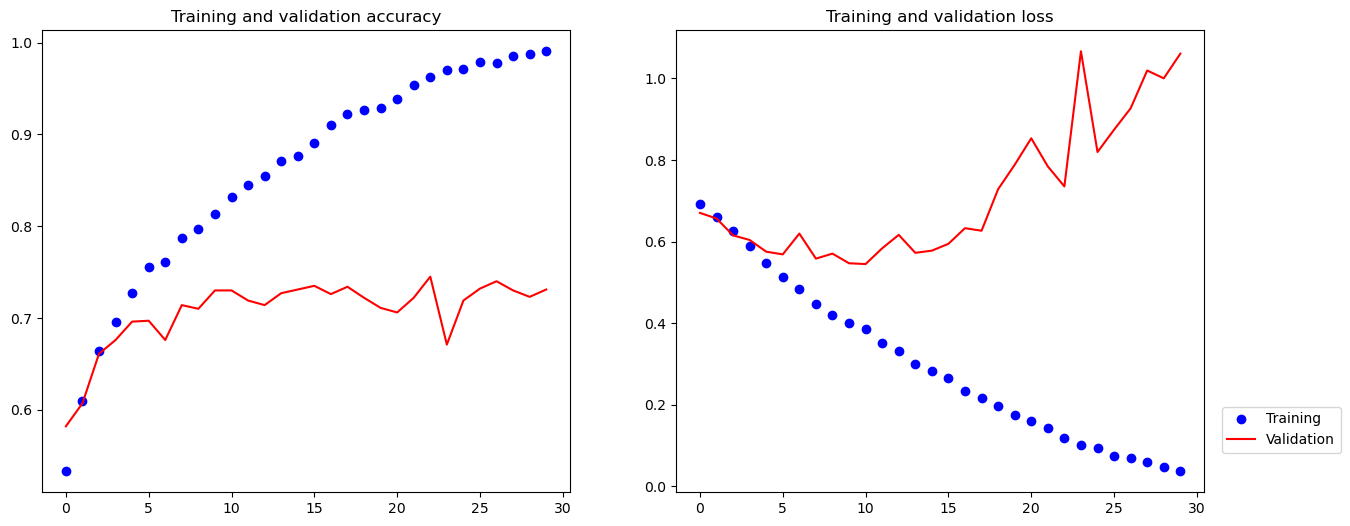

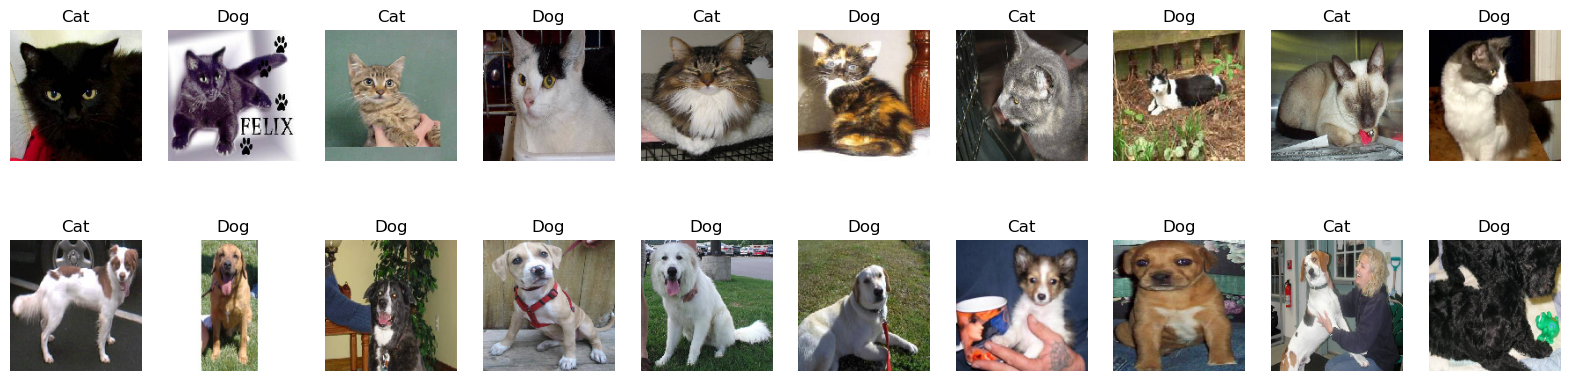

In [ ]:
def build_model():
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    train_dir = './dogs-vs-cats_small/train'
    validation_dir = './dogs-vs-cats_small/validation'      
    
    # build data generator
    # that can automatically turn image files into batches of preprocessed tensors
    train_datagen = image.ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            train_dir,
            # All images will be resized to 150x150
            target_size=(150, 150), batch_size=20,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

    validation_datagen = image.ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                                  batch_size=20, class_mode='binary')
    for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    # build model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc'])
    
    # fit model and get validation information
    history = model.fit(train_generator, steps_per_epoch=100, epochs=30, 
                        validation_data=validation_generator, validation_steps=50, verbose=0)
    # with open('history_cats_and_dogs_small_1.pkl', 'wb') as f:
        # pickle.dump(history.history, f)
    history = history.history
    
    return model, history

# model, history = build_model()
model = models.load_model(get_file(origin = base + '/data/cats_and_dogs_small_1.h5'))
history = pickle.loads(urlopen(base + "data/history_cats_and_dogs_small_1.pkl").read())

model.summary()
validation_plot(history)    
plot_test_images(model)
K.clear_session()

The accuracy and loss plots are characteristic of overfitting. 

- The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at low percentages. 

- the training loss keeps decreasing linearly until it reaches nearly 0, whereas the validation loss reaches its minimum after only 5-10 epochs. 

Overfitting is a significant concern since we only have 2,000 training samples. This problem is caused by having too few samples to learn from, which can result in an inability to train a model that can generalize to new data. To mitigate this issue, we will use data augmentation, a technique that is specific to computer vision and is almost universally used when processing images with deep-learning models.

## Data Augmentation

Data augmentation is a technique that generates more training data from existing training samples. It works by augmenting the samples through a number of random transformations that yield believable-looking images.

The code block demonstrates the augmented images:

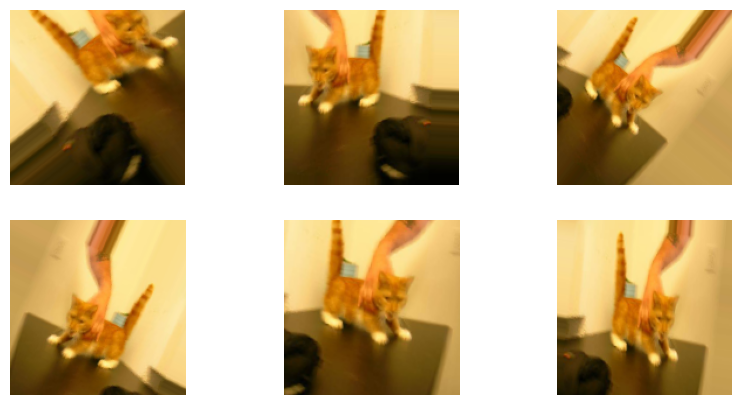

In [ ]:
train_dir = './dogs-vs-cats_small/train'
train_datagen = image.ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                         height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                         horizontal_flip=True, fill_mode='nearest')

index = 0
# We pick one image to "augment"
img_path = os.path.join(train_cats_dir, os.listdir(train_dir+'/cats')[index])
# Read the image and resize it
# Convert it to a Numpy array with shape (150, 150, 3)
x = img_to_array(load_img(img_path, target_size=(150, 150)))
# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
fig = plt.figure(figsize=(10,5))
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
for i, batch in enumerate(train_datagen.flow(x, batch_size=1)):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(array_to_img(batch[0]))
    if i==5:
        break
plt.show()

With this data-augmentation configuration, the network will now be exposed to many new training inputs.

However, since the augmented samples are based on a limited number of original images and created by remixing existing information, data augmentation alone may not be sufficient to eliminate overfitting. Therefore, a Dropout layer will be added to the model just before the densely connected classifier to further address this issue.

27683984/27683984 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 34, 34, 128)       73856     
                                                       

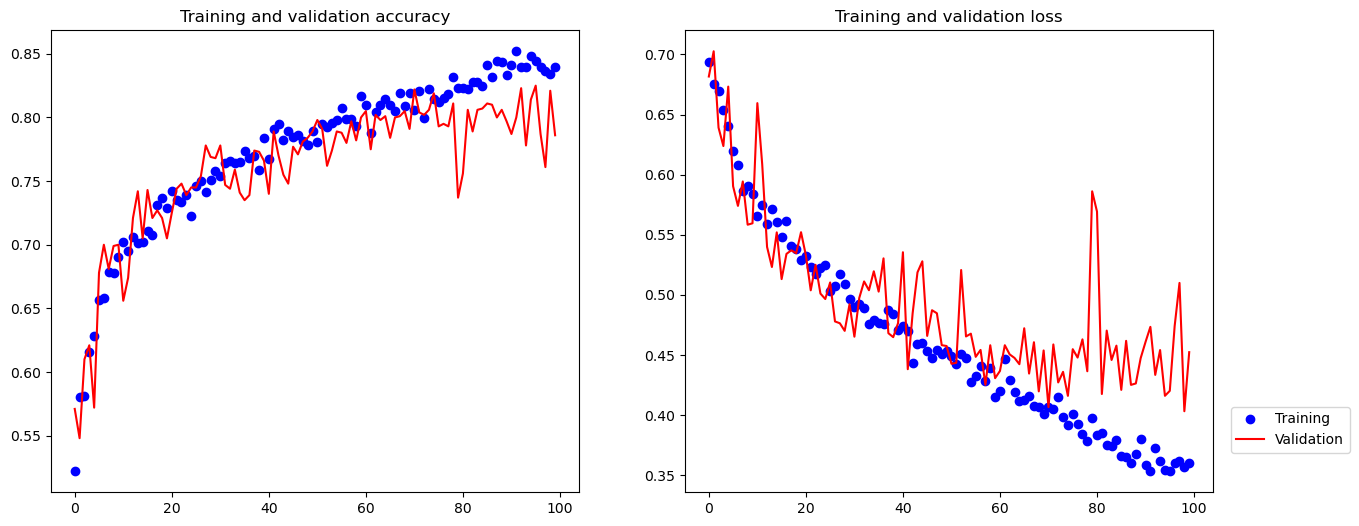

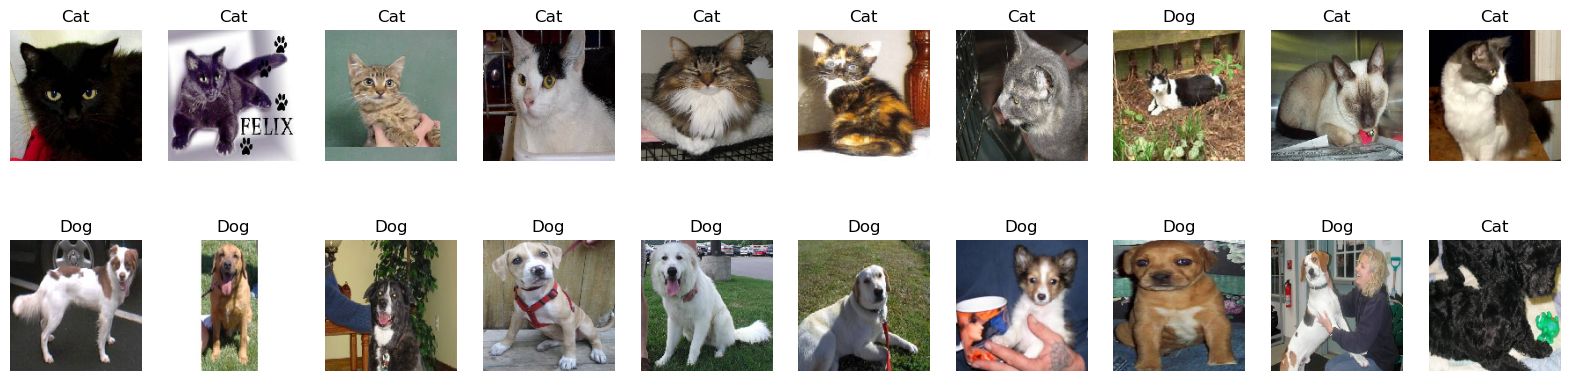

In [ ]:
def build_model():
    train_dir = './dogs-vs-cats_small/train'
    validation_dir = './dogs-vs-cats_small/validation'      
    
    # build data generator
    train_datagen = image.ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                             height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                             horizontal_flip=True, fill_mode='nearest')
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), 
                                                        batch_size=20, class_mode='binary')
    
    # Note that the validation data should not be augmented!
    validation_datagen = image.ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                                  batch_size=20, class_mode='binary')
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
    
    history = model.fit(train_generator, steps_per_epoch=100, epochs=100, 
                        validation_data=validation_generator, validation_steps=50, verbose=0)
    model.save('cats_and_dogs_small_2.h5')
    with open('history_cats_and_dogs_small_2.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    history = history.history    
    
    return model, history

# model, history = build_model()
model = models.load_model(get_file(origin=base + '/data/cats_and_dogs_small_2.h5'))
history = pickle.loads(urlopen(base + "data/history_cats_and_dogs_small_2.pkl").read())    

model.summary()
validation_plot(history)
plot_test_images(model)
K.clear_session()

## Pretrained

One of the benefits of deep learning models is their high degree of reusability. For example, an image-classification or speech-to-text model trained on a large-scale dataset can be adapted to a significantly different problem with only minor adjustments.

There are numerous [pretrained models](https://keras.io/api/applications/) in computer vision publicly available for download, typically trained on the ImageNet dataset. Next, we will utilize such models to tackle our problem.

75706016/75706016 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


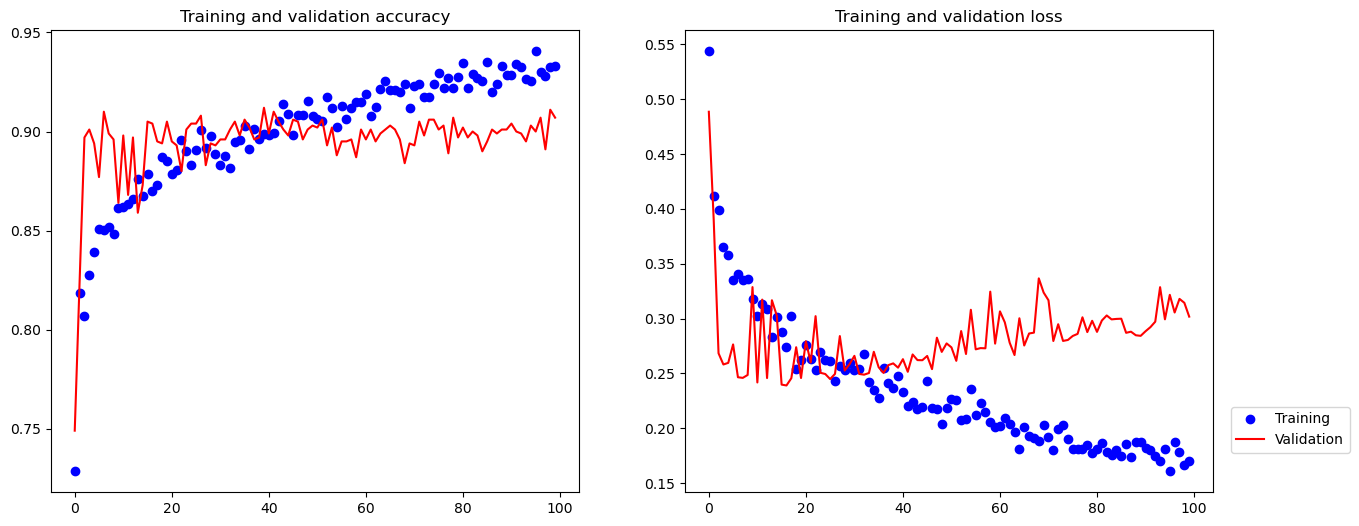

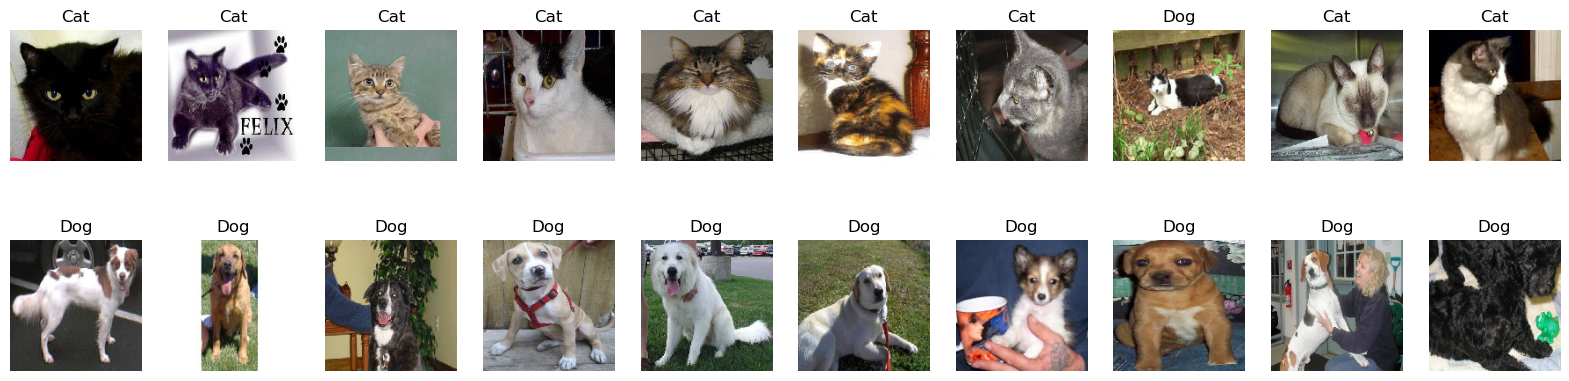

In [ ]:
from keras.applications import VGG16

def build_model():
    train_datagen = image.ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                       height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                       horizontal_flip=True, fill_mode='nearest')
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), 
                                                        batch_size=20, class_mode='binary')
    
    # Note that the validation data should not be augmented!
    validation_datagen = image.ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                                  batch_size=20, class_mode='binary')    
    
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    conv_base.trainable = False
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc'])
    history = model.fit(train_generator, steps_per_epoch=100, epochs=100, 
                        validation_data=validation_generator, validation_steps=50, verbose=0)
    # model.save('cats_and_dogs_small_3.h5')
    # with open('history_cats_and_dogs_small_3.pkl', 'wb') as f:
    #    pickle.dump(history.history, f)
    history = history.history    
    
    return model, history
    
# model, history = build_model()
model = models.load_model(get_file(origin=base + '/data/cats_and_dogs_small_3.h5'))
history = pickle.loads(urlopen(base + "data/history_cats_and_dogs_small_3.pkl").read())

model.summary()
validation_plot(history)
plot_test_images(model)
K.clear_session()    

# Visualizing Convnets

## Intermediate Outputs

In [ ]:
def show_conv_output(layer_name):
    url = base + "data/dogs-vs-cats_small_test/cat.{}.jpg?raw=true".format(1500)
    img = load_img(get_file(origin=url), target_size=(150, 150))
    img_tensor = np.expand_dims(img_to_array(img), axis=0)
    img_tensor /= 255.

    plt.figure(figsize=(3, 3))
    plt.imshow(img_tensor[0])
    plt.title('original')
    plt.axis('off')
    plt.show()
    
    model = models.load_model(get_file(origin=base + '/data/cats_and_dogs_small_2.h5'))
    layer_outputs = [layer.output for layer in model.layers[:8]]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)

    layer_names = [layer.name for layer in model.layers[:8]]

    images_per_row = 16
    layer_activation = activations[layer_names.index(layer_name)]

    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1]/0.9,
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.colorbar(pad=0.01)

    plt.show()

In [ ]:
layer_names = [layer.name for layer in model.layers[:8] if 'conv' in layer.name]
interact(show_conv_output, layer_name=layer_names);

interactive(children=(Dropdown(description='layer_name', options=('conv2d_28', 'conv2d_29', 'conv2d_30', 'conv…

## Filters

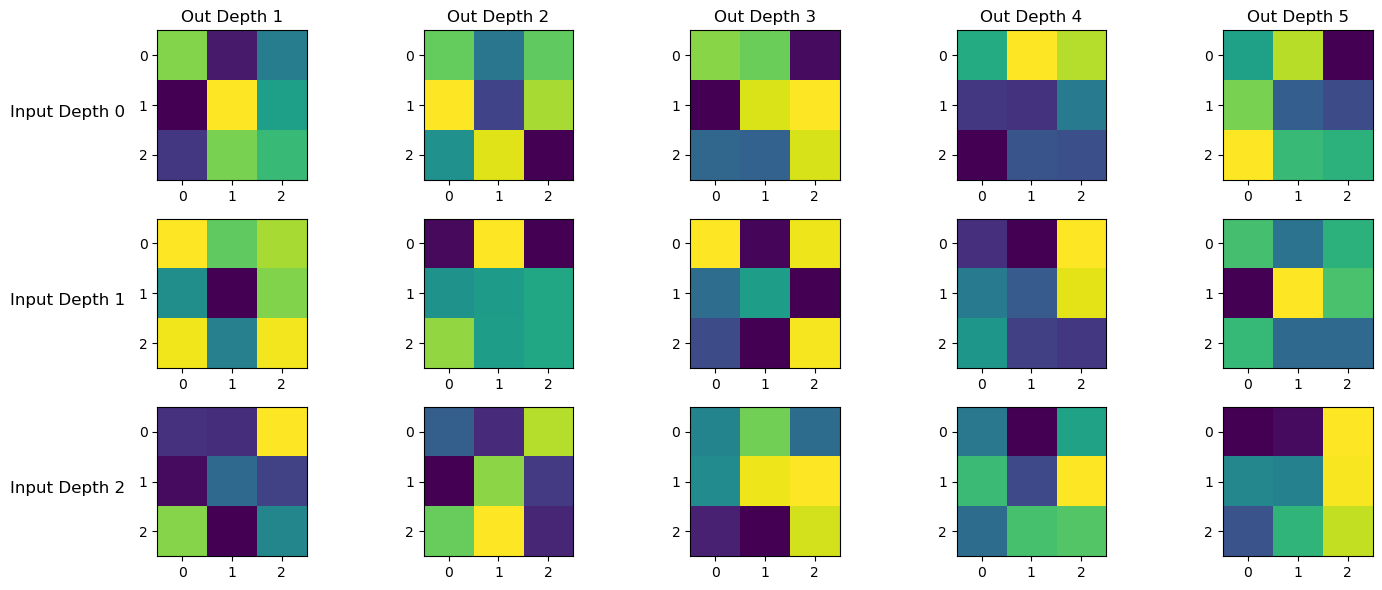

In [ ]:
def filters(idx):
    layer_name = 'conv2d_28'
    filters, biases = model.get_layer(layer_name).get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    fig, axes =  plt.subplots(3, 5, figsize=(15, 6))
    cols = ['Out Depth {}'.format(col+idx) for col in range(5)]
    rows = ['Input Depth {}'.format(row) for row in range(3)]
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size='large')
        ax.yaxis.set_label_coords(-.6,.4)
    for i in range(3):
        for j in range(5):
            axes[i,j].imshow(filters[:, :, i, idx+j])
    fig.tight_layout()
    plt.show()
    
filters(1)    

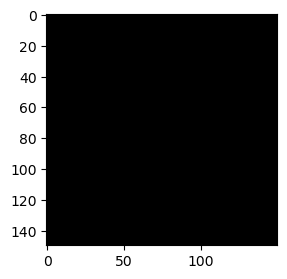

In [ ]:
input_img_data = np.zeros((1, 150, 150, 3)) * 20 + 128
plt.figure(figsize=(3, 3))
plt.imshow(array_to_img(input_img_data[0]))
plt.show()

## Heatmaps of Class Activation
The technique used for understanding which parts of a given image led a convnet to its final classification decision is called class activation map (CAM) visualization.

A class activation heatmap is a matrix of scores associated with a specific output class. Let's use the VGG16 model and an elephant picture as an example. The final convolutional layer in VGG16 is called "block5_conv3" and has an output shape of (None, 14, 14, 512), which consists of 512 14x14 filter images.

\begin{align*}
\text{Heatmap} = \sum_{\text{sum over 512 filter images}} \big( \text{each 14 $\times$ 14 filter image} \big) \times \text{weight}
\end{align*}

where `weight` shows how important this filter is with regard to the "elephant" class and, techniqually, is related to gradient of the of the "elephant" class with regard to the output of layer `block5_conv3`.

Given an image fed into VGG16, CAM visualization overlays the heatmap on the image and indicates how important each location in the image is with respect to the class under consideration.

The following code block contains functions that generate heatmaps and display class activation map.

In [ ]:
def make_gradcam_heatmap(model, img_path, pred_index=None):
    import tensorflow as tf
    last_conv_layer_name = [layer for layer in model.layers if 'conv' in layer.name][-1].name
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    img = load_img(img_path, target_size=model.layers[0].output_shape[0][1:3])
    img_array = preprocess_input(np.expand_dims(img_to_array(img), axis=0))
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(heatmap, img_path, alpha=0.4):
    from matplotlib.pyplot import get_cmap
    # Load the original image
    
    img = load_img(img_path)
    img_array = img_to_array(img)    
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = array_to_img(superimposed_img)

    # Display Grad CAM
    #plt.matshow(deprocess_image(superimposed_img))
    plt.imshow(superimposed_img)
    plt.show()

The default code uses the VGG16 model on an elephant picture. You can uncomment the code to use the Xception model or a picture of a cat and a dog. Changing the `pred_index` value (the default value None indicating the predicted class) to another class will show the class activation map of that specific class.

For instance, the CAM visualization shows that the Xception model predicts the cat and dog as the top two classes, while VGG16 fails to predict the cat class.

1/1 [==============================] - 0s 265ms/step
Preds index [386 101 385]
Predicted: [('n02504458', 'African_elephant', 0.90942127), ('n01871265', 'tusker', 0.08618274), ('n02504013', 'Indian_elephant', 0.0043545836)]


<Figure size 100x100 with 0 Axes>

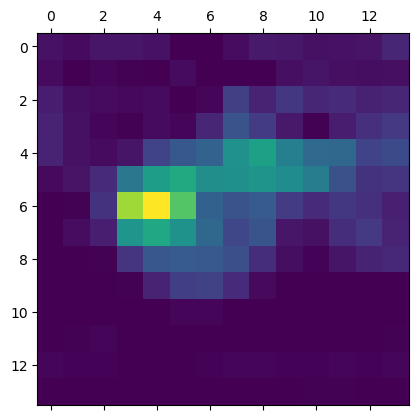

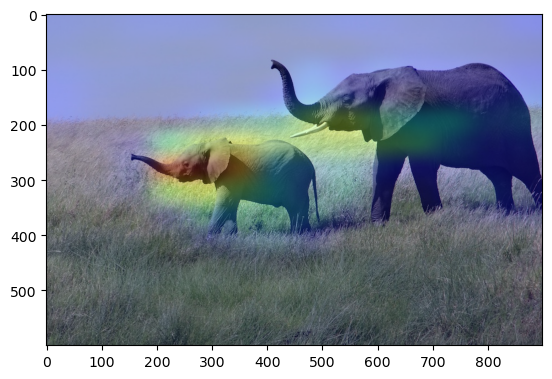

In [ ]:
model = VGG16(weights='imagenet')
from keras.applications.vgg16 import preprocess_input, decode_predictions

# model = xception.Xception(weights='imagenet')
# from keras.applications.xception import preprocess_input, decode_predictions
  
img_path = get_file(origin=base+'figures/african_elephant.jpg')
# img_path = get_file(origin=base+'figures/cat_and_dog.jpg') 

img = load_img(img_path, target_size=model.layers[0].output_shape[0][1:3])
img_array = preprocess_input(np.expand_dims(img_to_array(img), axis=0))
preds = model.predict(img_array) # with shape (1, 1000)
# print('argmax(preds):', np.argmax(preds[0]))
print('Preds index', (-preds[0]).argsort()[:3])
print('Predicted:', decode_predictions(preds, top=3)[0])

heatmap = make_gradcam_heatmap(model, img_path, pred_index=None)
plt.figure(figsize=(1, 1))
plt.matshow(heatmap)
plt.show()
display_gradcam(heatmap, img_path)